In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import math
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns
import numpy as np
import random
from imblearn.over_sampling import SMOTE
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testdulabo/RES.csv
/kaggle/input/resultatswithotdesc/resultat.csv


# I. Dataset Creation and Cleaning


In [2]:
file_path = '/kaggle/input/resultatswithotdesc/resultat.csv'
df = pd.read_csv(file_path)

**First Visualization of the dataset :**

In [3]:
df.head()

Components  Temperature K  \
0  1-ethyl-3-methylimidazolium trifluoromethanesu...          282.9   
1  1-ethyl-3-methylimidazolium trifluoromethanesu...          298.1   
2  1-ethyl-3-methylimidazolium trifluoromethanesu...          312.8   
3  1-ethyl-3-methylimidazolium trifluoromethanesu...          327.9   
4  1-ethyl-3-methylimidazolium trifluoromethanesu...          347.9   

   Pressure kPa  Viscosity Pa/s  DeltaViscosity  \
0       101.325        0.000056    7.000000e-07   
1       101.325        0.000031    4.000000e-07   
2       101.325        0.000019    3.000000e-07   
3       101.325        0.000012    2.000000e-07   
4       101.325        0.000008    1.000000e-07   

                                      SMILES  
0  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C  
1  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C  
2  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C  
3  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C  
4  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C

DeltaViscosity won't be a relevant feature in our study, we can drop it.




In [4]:
df = df.drop(["DeltaViscosity"], axis=1)

Displaying the dataset :

In [5]:
df.head()

Components  Temperature K  \
0  1-ethyl-3-methylimidazolium trifluoromethanesu...          282.9   
1  1-ethyl-3-methylimidazolium trifluoromethanesu...          298.1   
2  1-ethyl-3-methylimidazolium trifluoromethanesu...          312.8   
3  1-ethyl-3-methylimidazolium trifluoromethanesu...          327.9   
4  1-ethyl-3-methylimidazolium trifluoromethanesu...          347.9   

   Pressure kPa  Viscosity Pa/s                                     SMILES  
0       101.325        0.000056  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C  
1       101.325        0.000031  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C  
2       101.325        0.000019  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C  
3       101.325        0.000012  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C  
4       101.325        0.000008  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C

**Cleaning of N/A row :**

In [6]:
print(df.isna().sum())

Components           0
Temperature K        0
Pressure kPa         0
Viscosity Pa/s       0
SMILES            2180
dtype: int64


In [7]:
df_cleaned = df.dropna()
print(df_cleaned.shape)


(19120, 5)




The 'SMILES' and 'Components' columns contain string data with an infinite number of unique values, making them unsuitable for direct encoding. Utilizing these features requires advanced techniques such as NLP. Hence, these columns are excluded from our dataset. We won't be interested in "DeltaViscosity" feature in this study.

In [8]:
!pip install rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 41.6 MB/s eta 0:00:00


In [9]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen, MolSurf

# Define a function to calculate descriptors
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Handle invalid SMILES strings
    descriptors = {
        'AtomCount': mol.GetNumAtoms(),
        'BondCount': mol.GetNumBonds(),
        'ElementCount': len(set(atom.GetSymbol() for atom in mol.GetAtoms())),
        'HBondAcceptorCount': Descriptors.NumHAcceptors(mol),
        'HBondDonorCount': Descriptors.NumHDonors(mol),
        'HybridizationRatio_SP3': sum(1 for atom in mol.GetAtoms() if atom.GetHybridization() == Chem.rdchem.HybridizationType.SP3) / mol.GetNumAtoms(),
        'RotatableBondCount': Descriptors.NumRotatableBonds(mol),
        'TopologicalPolarSurfaceArea': Descriptors.TPSA(mol),
        'ExactMolWeight': rdMolDescriptors.CalcExactMolWt(mol),
        'MolMR': Descriptors.MolMR(mol),
        'MolLogP': Descriptors.MolLogP(mol),
        'CarbonCount': sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'C'),
        'RingCount': Descriptors.RingCount(mol),
        'LipinskiRuleOfFive': int(all([
            Descriptors.MolWt(mol) < 500,
            Descriptors.NumHAcceptors(mol) <= 10,
            Descriptors.NumHDonors(mol) <= 5,
            Descriptors.MolLogP(mol) < 5
        ])),
        'VeberRule': int(all([
            Descriptors.TPSA(mol) <= 140,
            Descriptors.NumRotatableBonds(mol) <= 10
        ])),
        'NumAliphaticRings': Descriptors.NumAliphaticRings(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'NumSaturatedRings': Descriptors.NumSaturatedRings(mol),
        'FractionCSP3': Descriptors.FractionCSP3(mol),
        'HeavyAtomCount': Descriptors.HeavyAtomCount(mol),
        'NHOHCount': Descriptors.NHOHCount(mol),
        'NOCount': Descriptors.NOCount(mol),
        'NumValenceElectrons': Descriptors.NumValenceElectrons(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumAromaticHeterocycles': Descriptors.NumAromaticHeterocycles(mol),
        'NumAliphaticHeterocycles': Descriptors.NumAliphaticHeterocycles(mol),
        'ALogP': Descriptors.MolLogP(mol),  
        'XLogP': Descriptors.MolLogP(mol),
        'MolWt': Descriptors.MolWt(mol),
        'PolarSurfaceArea': Descriptors.TPSA(mol),
        'MolecularVolume': Descriptors.MolMR(mol),  
        'BalabanIndex': Descriptors.BalabanJ(mol),
        'KierHallAlpha': Descriptors.Kappa1(mol)  
     
        
    }
    return descriptors

def process_ionic_liquid(smiles):
    try:
        cation_smiles, anion_smiles = smiles.split('.')
    except ValueError:
        return None  
    cation_descriptors = calculate_descriptors(cation_smiles)
    anion_descriptors = calculate_descriptors(anion_smiles)
    if cation_descriptors and anion_descriptors:
        combined_descriptors = {}
        for key in cation_descriptors:
            combined_descriptors[f'Cation_{key}'] = cation_descriptors[key]
            combined_descriptors[f'Anion_{key}'] = anion_descriptors[key]
        return combined_descriptors
    return None

df_descriptors = df_cleaned['SMILES'].apply(process_ionic_liquid)

valid_mask = df_descriptors.notnull()

df_cleaned = df_cleaned[valid_mask].reset_index(drop=True)
df_descriptors = pd.DataFrame(list(df_descriptors.dropna()))

df_cleaned = pd.concat([df_cleaned, df_descriptors], axis=1)
df_cleaned.head()


Components  Temperature K  \
0  1-ethyl-3-methylimidazolium trifluoromethanesu...          282.9   
1  1-ethyl-3-methylimidazolium trifluoromethanesu...          298.1   
2  1-ethyl-3-methylimidazolium trifluoromethanesu...          312.8   
3  1-ethyl-3-methylimidazolium trifluoromethanesu...          327.9   
4  1-ethyl-3-methylimidazolium trifluoromethanesu...          347.9   

   Pressure kPa  Viscosity Pa/s                                     SMILES  \
0       101.325        0.000056  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C   
1       101.325        0.000031  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C   
2       101.325        0.000019  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C   
3       101.325        0.000012  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C   
4       101.325        0.000008  FC(S(=O)(=O)[O-])(F)F.C(C)N1C=[N+](C=C1)C   

   Cation_AtomCount  Anion_AtomCount  Cation_BondCount  Anion_BondCount  \
0                 8                8                 7                8   
1                 8                8                 7                8   
2                 8                8                 7                8   
3                 8                8                 7                8   
4                 8                8                 7                8   

   Cation_ElementCount  ...  Cation_MolWt  Anion_MolWt  \
0                    4  ...       149.069      111.168   
1                    4  ...       149.069      111.168   
2                    4  ...       149.069      111.168   
3                    4  ...       149.069      111.168   
4                    4  ...       149.069      111.168   

   Cation_PolarSurfaceArea  Anion_PolarSurfaceArea  Cation_MolecularVolume  \
0                     57.2                    8.81                 15.7522   
1                     57.2                    8.81                 15.7522   
2                     57.2                    8.81                 15.7522   
3                     57.2                    8.81                 15.7522   
4                     57.2                    8.81                 15.7522   

   Anion_MolecularVolume  Cation_BalabanIndex  Anion_BalabanIndex  \
0                 31.282             4.534785            2.837541   
1                 31.282             4.534785            2.837541   
2                 31.282             4.534785            2.837541   
3                 31.282             4.534785            2.837541   
4                 31.282             4.534785            2.837541   

   Cation_KierHallAlpha  Anion_KierHallAlpha  
0                   7.7             5.348696  
1                   7.7             5.348696  
2                   7.7             5.348696  
3                   7.7             5.348696  
4                   7.7             5.348696  

[5 rows x 71 columns]

In [10]:
df_cleaned = df_cleaned.drop(["SMILES"], axis=1)
df_cleaned["Viscosity Pa/s"] = df_cleaned["Viscosity Pa/s"] 


**Visualization of our cleaned dataset :**

In [11]:
df_cleaned.head()

Components  Temperature K  \
0  1-ethyl-3-methylimidazolium trifluoromethanesu...          282.9   
1  1-ethyl-3-methylimidazolium trifluoromethanesu...          298.1   
2  1-ethyl-3-methylimidazolium trifluoromethanesu...          312.8   
3  1-ethyl-3-methylimidazolium trifluoromethanesu...          327.9   
4  1-ethyl-3-methylimidazolium trifluoromethanesu...          347.9   

   Pressure kPa  Viscosity Pa/s  Cation_AtomCount  Anion_AtomCount  \
0       101.325        0.000056                 8                8   
1       101.325        0.000031                 8                8   
2       101.325        0.000019                 8                8   
3       101.325        0.000012                 8                8   
4       101.325        0.000008                 8                8   

   Cation_BondCount  Anion_BondCount  Cation_ElementCount  Anion_ElementCount  \
0                 7                8                    4                   2   
1                 7                8                    4                   2   
2                 7                8                    4                   2   
3                 7                8                    4                   2   
4                 7                8                    4                   2   

   ...  Cation_MolWt  Anion_MolWt  Cation_PolarSurfaceArea  \
0  ...       149.069      111.168                     57.2   
1  ...       149.069      111.168                     57.2   
2  ...       149.069      111.168                     57.2   
3  ...       149.069      111.168                     57.2   
4  ...       149.069      111.168                     57.2   

   Anion_PolarSurfaceArea  Cation_MolecularVolume  Anion_MolecularVolume  \
0                    8.81                 15.7522                 31.282   
1                    8.81                 15.7522                 31.282   
2                    8.81                 15.7522                 31.282   
3                    8.81                 15.7522                 31.282   
4                    8.81                 15.7522                 31.282   

   Cation_BalabanIndex  Anion_BalabanIndex  Cation_KierHallAlpha  \
0             4.534785            2.837541                   7.7   
1             4.534785            2.837541                   7.7   
2             4.534785            2.837541                   7.7   
3             4.534785            2.837541                   7.7   
4             4.534785            2.837541                   7.7   

   Anion_KierHallAlpha  
0             5.348696  
1             5.348696  
2             5.348696  
3             5.348696  
4             5.348696  

[5 rows x 70 columns]

In [12]:
print(df_cleaned.isna().sum())

Components               0
Temperature K            0
Pressure kPa             0
Viscosity Pa/s           0
Cation_AtomCount         0
                        ..
Anion_MolecularVolume    0
Cation_BalabanIndex      0
Anion_BalabanIndex       0
Cation_KierHallAlpha     0
Anion_KierHallAlpha      0
Length: 70, dtype: int64


In [13]:
df_cleaned.dropna(inplace=True)




# II. EDA (Exploratory Data Analysis)

# **AUGMENTATION DU DATASET VOIR SCRIPT**

### Visualizing Data Distribution

To gain insights into the distribution of our dataset's numerical features, we plot histograms using the `hist` function of the DataFrame (`df`).

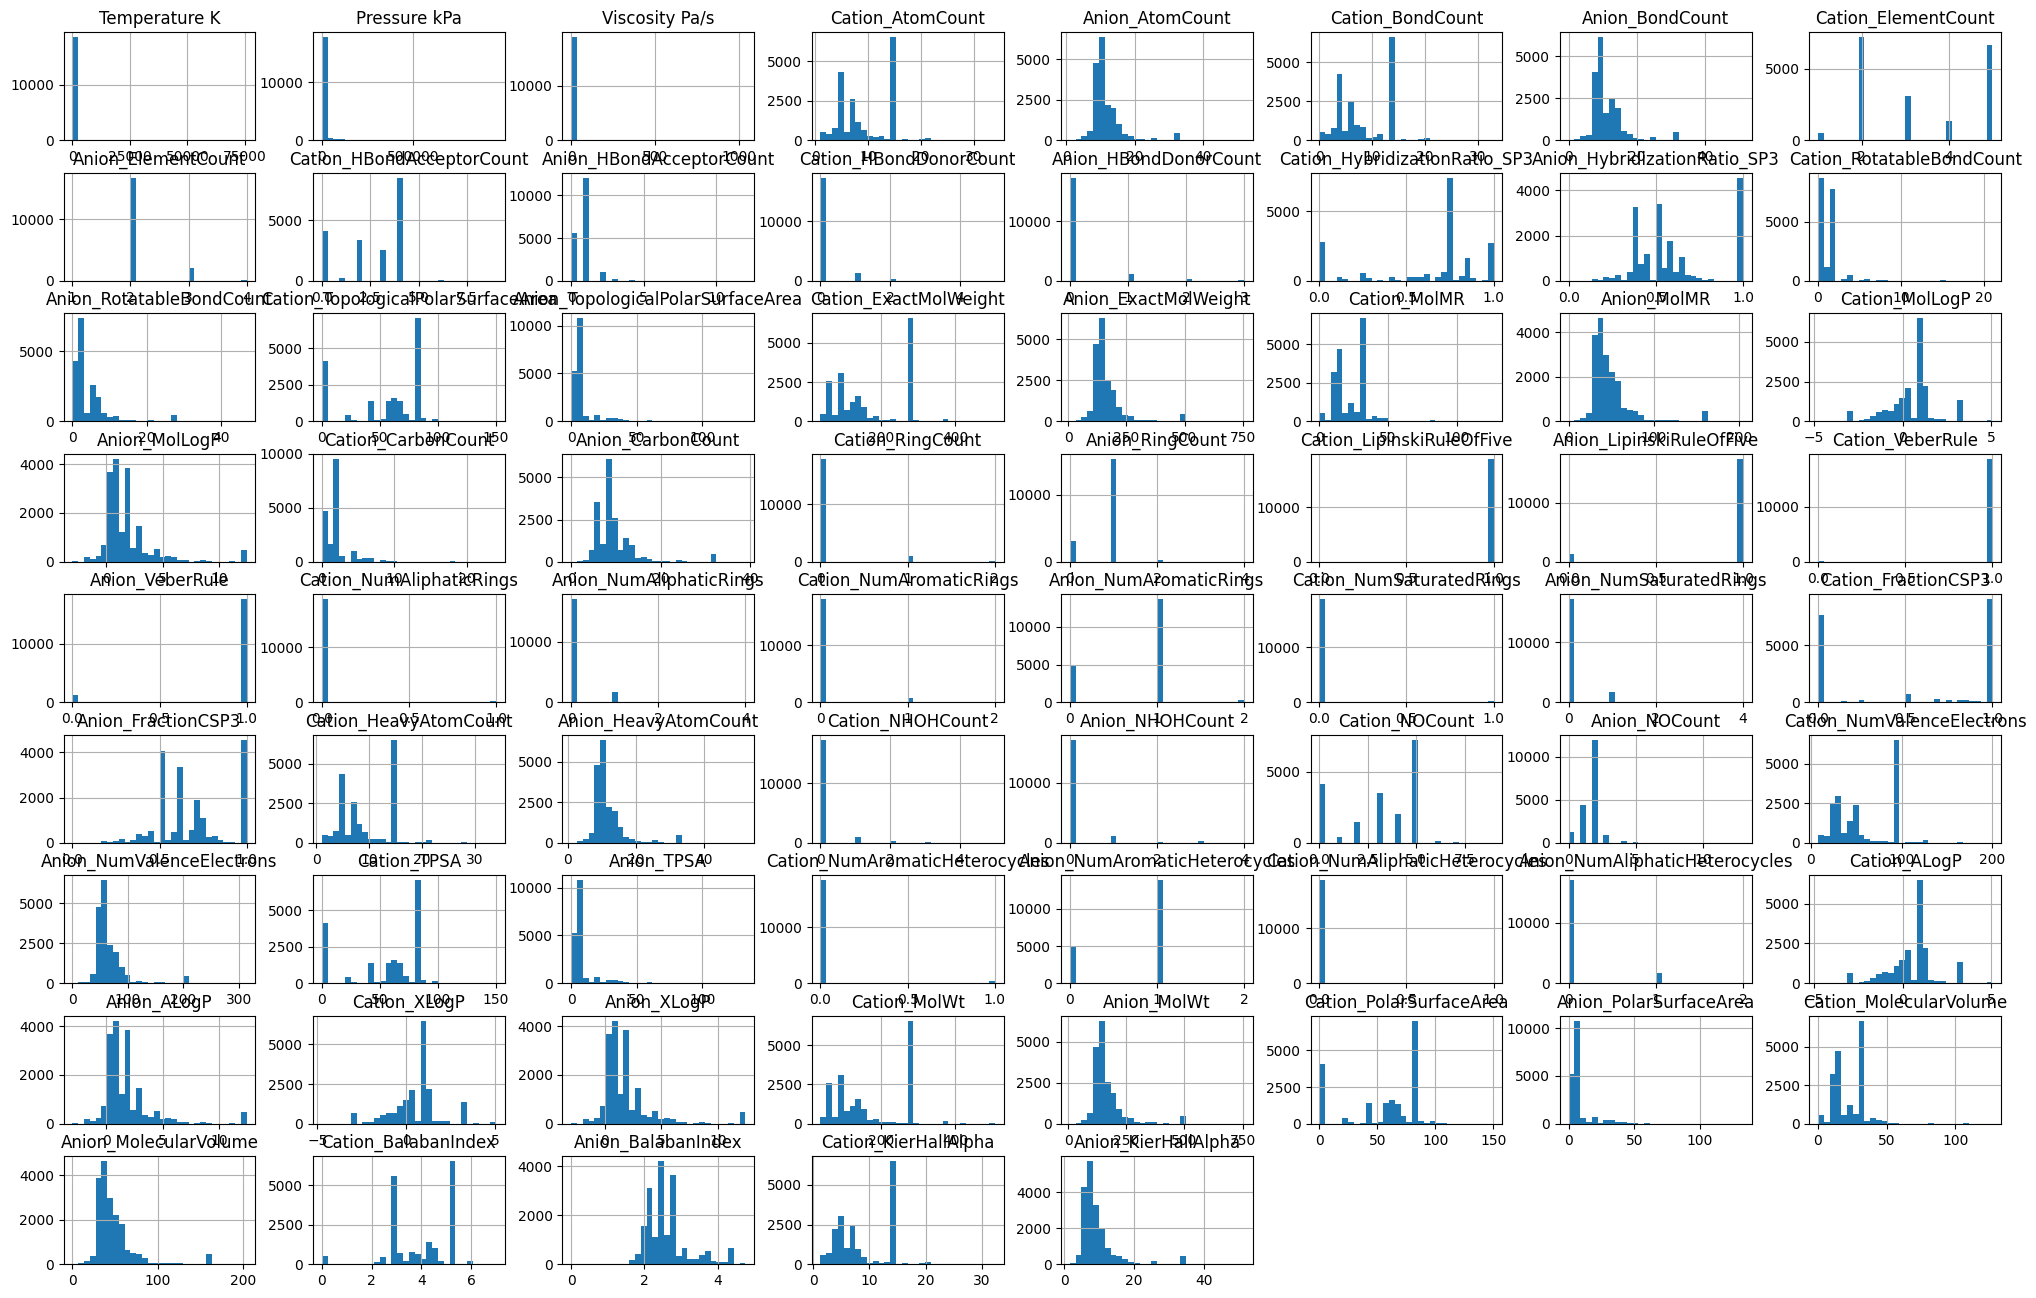

In [14]:
df_cleaned.hist(figsize=(25, 16), bins=30)
plt.show()

### Observations on the Distribution of Numerical Features

- **Temperature Distribution:**
  - The vast majority of temperature values are close to atmospheric temperature.
  - Temperatures above 400 K are rare and likely outliers.

- **Pressure Distribution:**
  - Most pressure values are near atmospheric pressure.
  - Pressures above 50 kPa are uncommon and likely outliers.

- **Skewed Distributions:**
  - The distributions of Molecular Weight (MolWt) and Molecular Volume are skewed.
  - Applying logarithmic transformations is recommended to normalize these distributions.

It is reasonable to remove outliers with temperatures above 400 K and pressures above 50 kPa to improve model performance.


In [15]:
df_cleaned = df_cleaned[(df_cleaned['Temperature K'] <= 400) & (df_cleaned['Pressure kPa'] <= 50000)].copy()

In [16]:
print(df_cleaned.shape)

(17346, 70)


We only have kept about 15K features upon the 21K that we got initially.

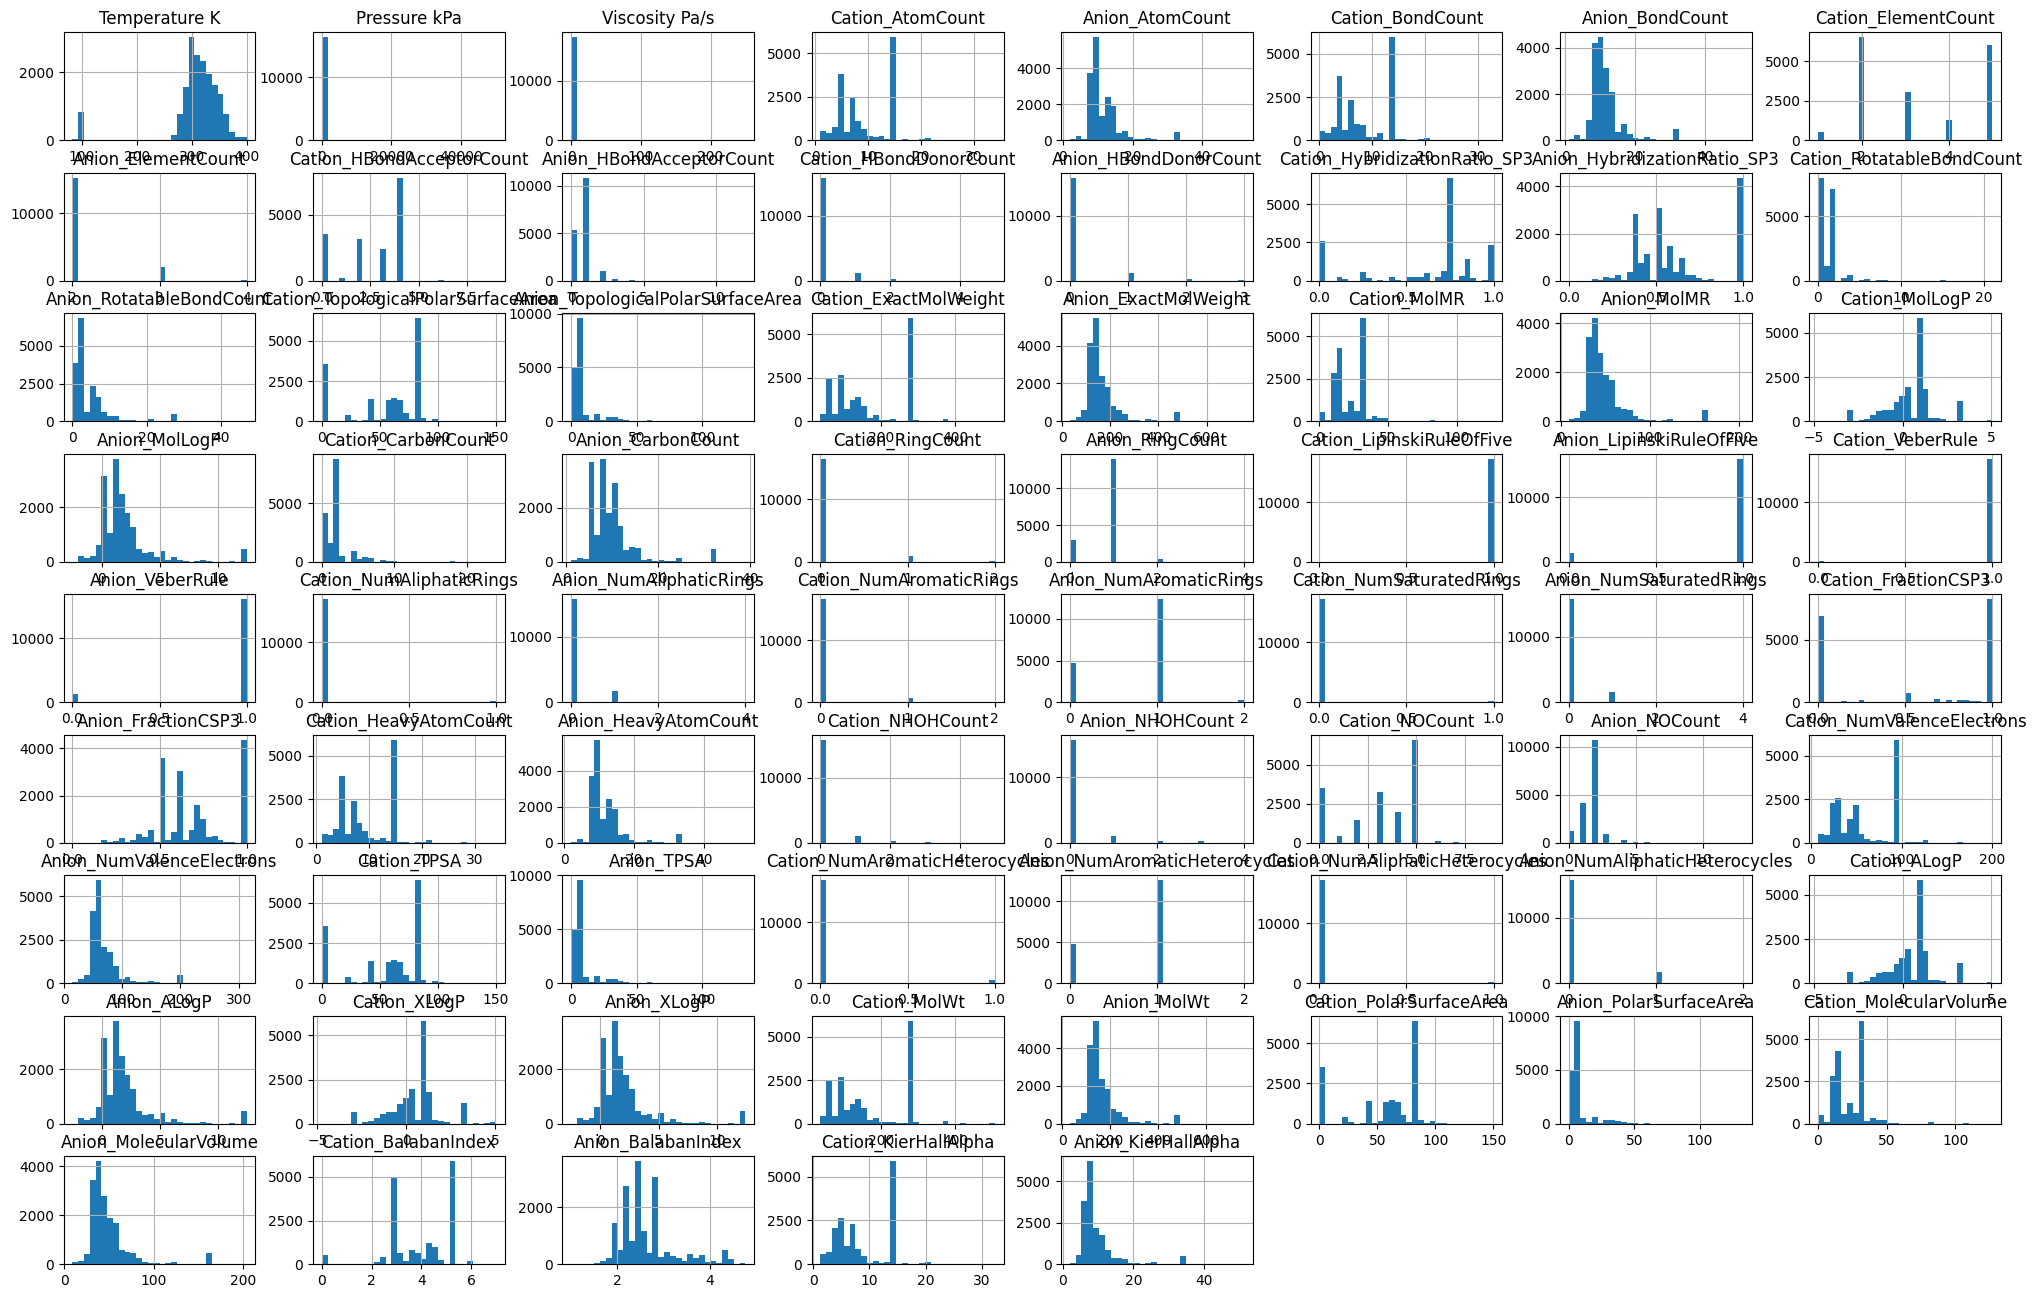

In [17]:
df_cleaned.hist(figsize=(25, 16), bins=30)
plt.show()

Certain values of temperature and pressure can be considered as outliers. Specifically,temperatures below 250K, viscosity above 1 and pressures above 200 KPa are unusual and may negatively impact the results of our model. By eliminating these extreme values, we can improve the quality of our predictions and achieve a more accurate and reliable model.

In [18]:
temperature_filtered_df = df_cleaned[
    (df_cleaned['Temperature K'] >= 275) & (df_cleaned['Temperature K'] <= 400)
]
print("Shape after temperature filter:", temperature_filtered_df.shape)

Shape after temperature filter: (16281, 70)


In [19]:
pressure_filtered_df = temperature_filtered_df[
    (temperature_filtered_df['Pressure kPa'] >= 97) & (temperature_filtered_df['Pressure kPa'] <= 103)
]
print("Shape after pressure filter:", pressure_filtered_df.shape)



Shape after pressure filter: (14958, 70)


In [20]:
viscosity_filtered_df = pressure_filtered_df[
    (pressure_filtered_df['Viscosity Pa/s'] <= 0.140) & (pressure_filtered_df['Viscosity Pa/s'] >= 0.008)
]
print("Shape after viscosity filter:", viscosity_filtered_df.shape)

Shape after viscosity filter: (10133, 70)


In [21]:
df_cleaned = viscosity_filtered_df.copy()

In [22]:
df_cleaned.drop("Components",axis = 1,inplace=True)

In [23]:
df_cleaned.tail()

Temperature K  Pressure kPa  Viscosity Pa/s  Cation_AtomCount  \
18813          343.0       101.325         0.01547                15   
18814          353.0       101.325         0.01206                15   
18815          303.0       101.325         0.04670                15   
18816          313.0       101.325         0.03230                15   
18817          323.0       101.325         0.02342                15   

       Anion_AtomCount  Cation_BondCount  Anion_BondCount  \
18813                5                14                5   
18814                5                14                5   
18815                7                14                7   
18816                7                14                7   
18817                7                14                7   

       Cation_ElementCount  Anion_ElementCount  Cation_HBondAcceptorCount  \
18813                    5                   2                          4   
18814                    5                   2                          4   
18815                    5                   2                          4   
18816                    5                   2                          4   
18817                    5                   2                          4   

       ...  Cation_MolWt  Anion_MolWt  Cation_PolarSurfaceArea  \
18813  ...       280.147       72.131                    82.38   
18814  ...       280.147       72.131                    82.38   
18815  ...       280.147       97.141                    82.38   
18816  ...       280.147       97.141                    82.38   
18817  ...       280.147       97.141                    82.38   

       Anion_PolarSurfaceArea  Cation_MolecularVolume  Anion_MolecularVolume  \
18813                   16.61                 33.3086                20.8934   
18814                   16.61                 33.3086                20.8934   
18815                   19.07                 33.3086                26.6617   
18816                   19.07                 33.3086                26.6617   
18817                   19.07                 33.3086                26.6617   

       Cation_BalabanIndex  Anion_BalabanIndex  Cation_KierHallAlpha  \
18813             5.284513            2.083333                 14.44   
18814             5.284513            2.083333                 14.44   
18815             5.284513            2.762608                 14.44   
18816             5.284513            2.762608                 14.44   
18817             5.284513            2.762608                 14.44   

       Anion_KierHallAlpha  
18813             3.161613  
18814             3.161613  
18815             4.371031  
18816             4.371031  
18817             4.371031  

[5 rows x 69 columns]

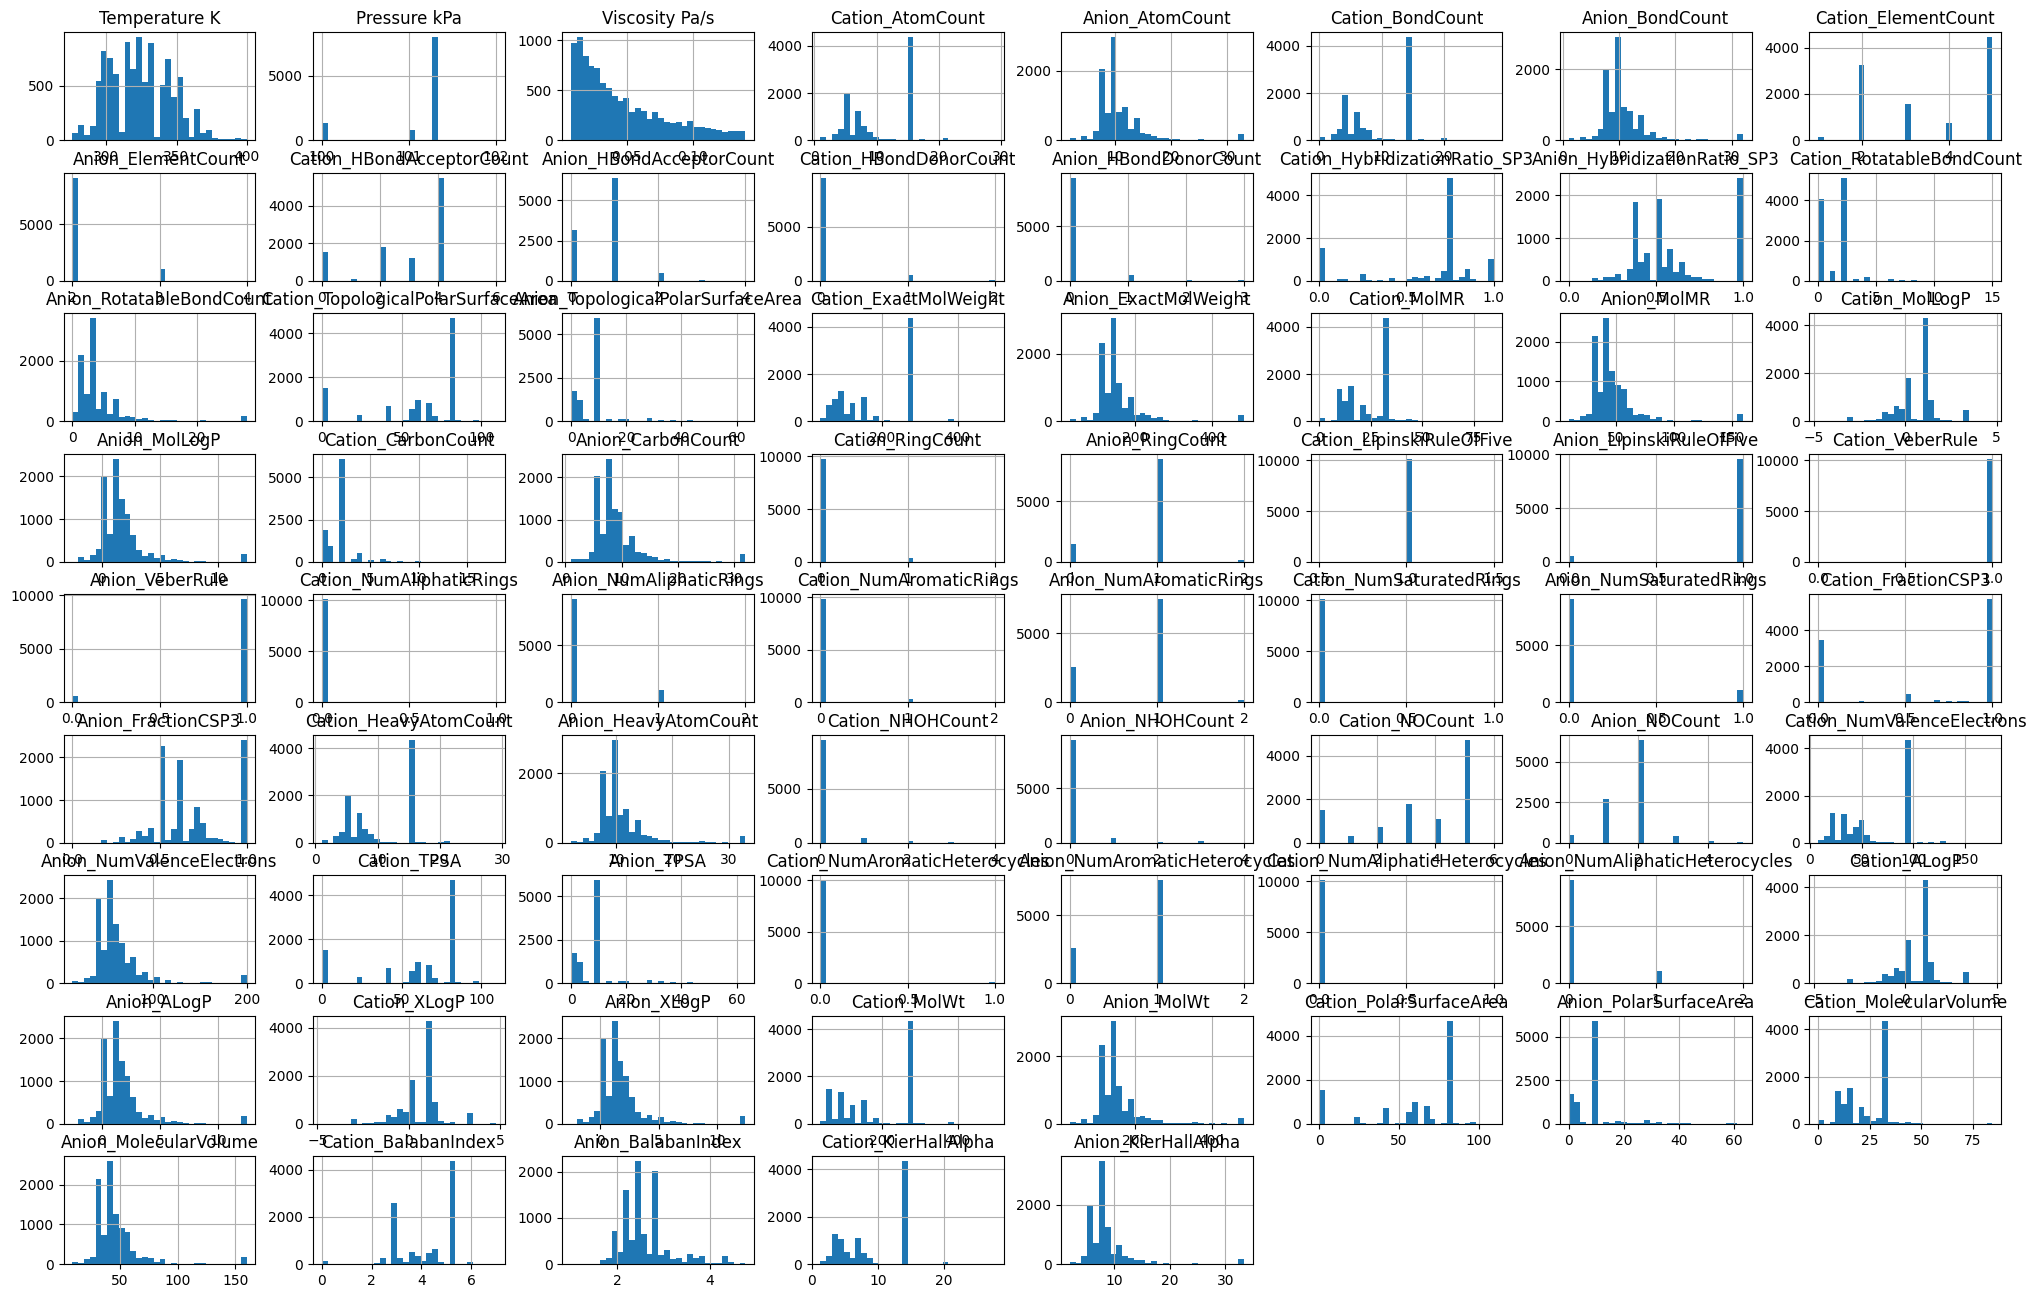

In [24]:
df_cleaned.hist(figsize=(25, 16), bins=30)
plt.show()

In [25]:
df_cleaned.columns

Index(['Temperature K', 'Pressure kPa', 'Viscosity Pa/s', 'Cation_AtomCount',
       'Anion_AtomCount', 'Cation_BondCount', 'Anion_BondCount',
       'Cation_ElementCount', 'Anion_ElementCount',
       'Cation_HBondAcceptorCount', 'Anion_HBondAcceptorCount',
       'Cation_HBondDonorCount', 'Anion_HBondDonorCount',
       'Cation_HybridizationRatio_SP3', 'Anion_HybridizationRatio_SP3',
       'Cation_RotatableBondCount', 'Anion_RotatableBondCount',
       'Cation_TopologicalPolarSurfaceArea',
       'Anion_TopologicalPolarSurfaceArea', 'Cation_ExactMolWeight',
       'Anion_ExactMolWeight', 'Cation_MolMR', 'Anion_MolMR', 'Cation_MolLogP',
       'Anion_MolLogP', 'Cation_CarbonCount', 'Anion_CarbonCount',
       'Cation_RingCount', 'Anion_RingCount', 'Cation_LipinskiRuleOfFive',
       'Anion_LipinskiRuleOfFive', 'Cation_VeberRule', 'Anion_VeberRule',
       'Cation_NumAliphaticRings', 'Anion_NumAliphaticRings',
       'Cation_NumAromaticRings', 'Anion_NumAromaticRings',
       'Cation_

In [26]:
df_cleaned.drop('Cation_LipinskiRuleOfFive',inplace = True, axis = 1)

In [27]:
df_cleaned.shape


(10133, 68)

In [28]:
non_numeric_columns = df_cleaned.select_dtypes(exclude=[np.number]).columns.tolist()
non_numeric_columns
df_cleaned = df_cleaned.select_dtypes(include=['number'])

In [29]:
non_numeric_columns = df_cleaned.select_dtypes(exclude=[np.number]).columns.tolist()
non_numeric_columns

[]

## Correlation Matrix
Correlation analysis helps identify relationships between variables. It allows us to understand which features are most relevant and which can be discarded. Here, we observe a low correlation between most features and viscosity, except for temperature. This suggests that temperature might be a significant predictor for viscosity, while other features may have less impact.


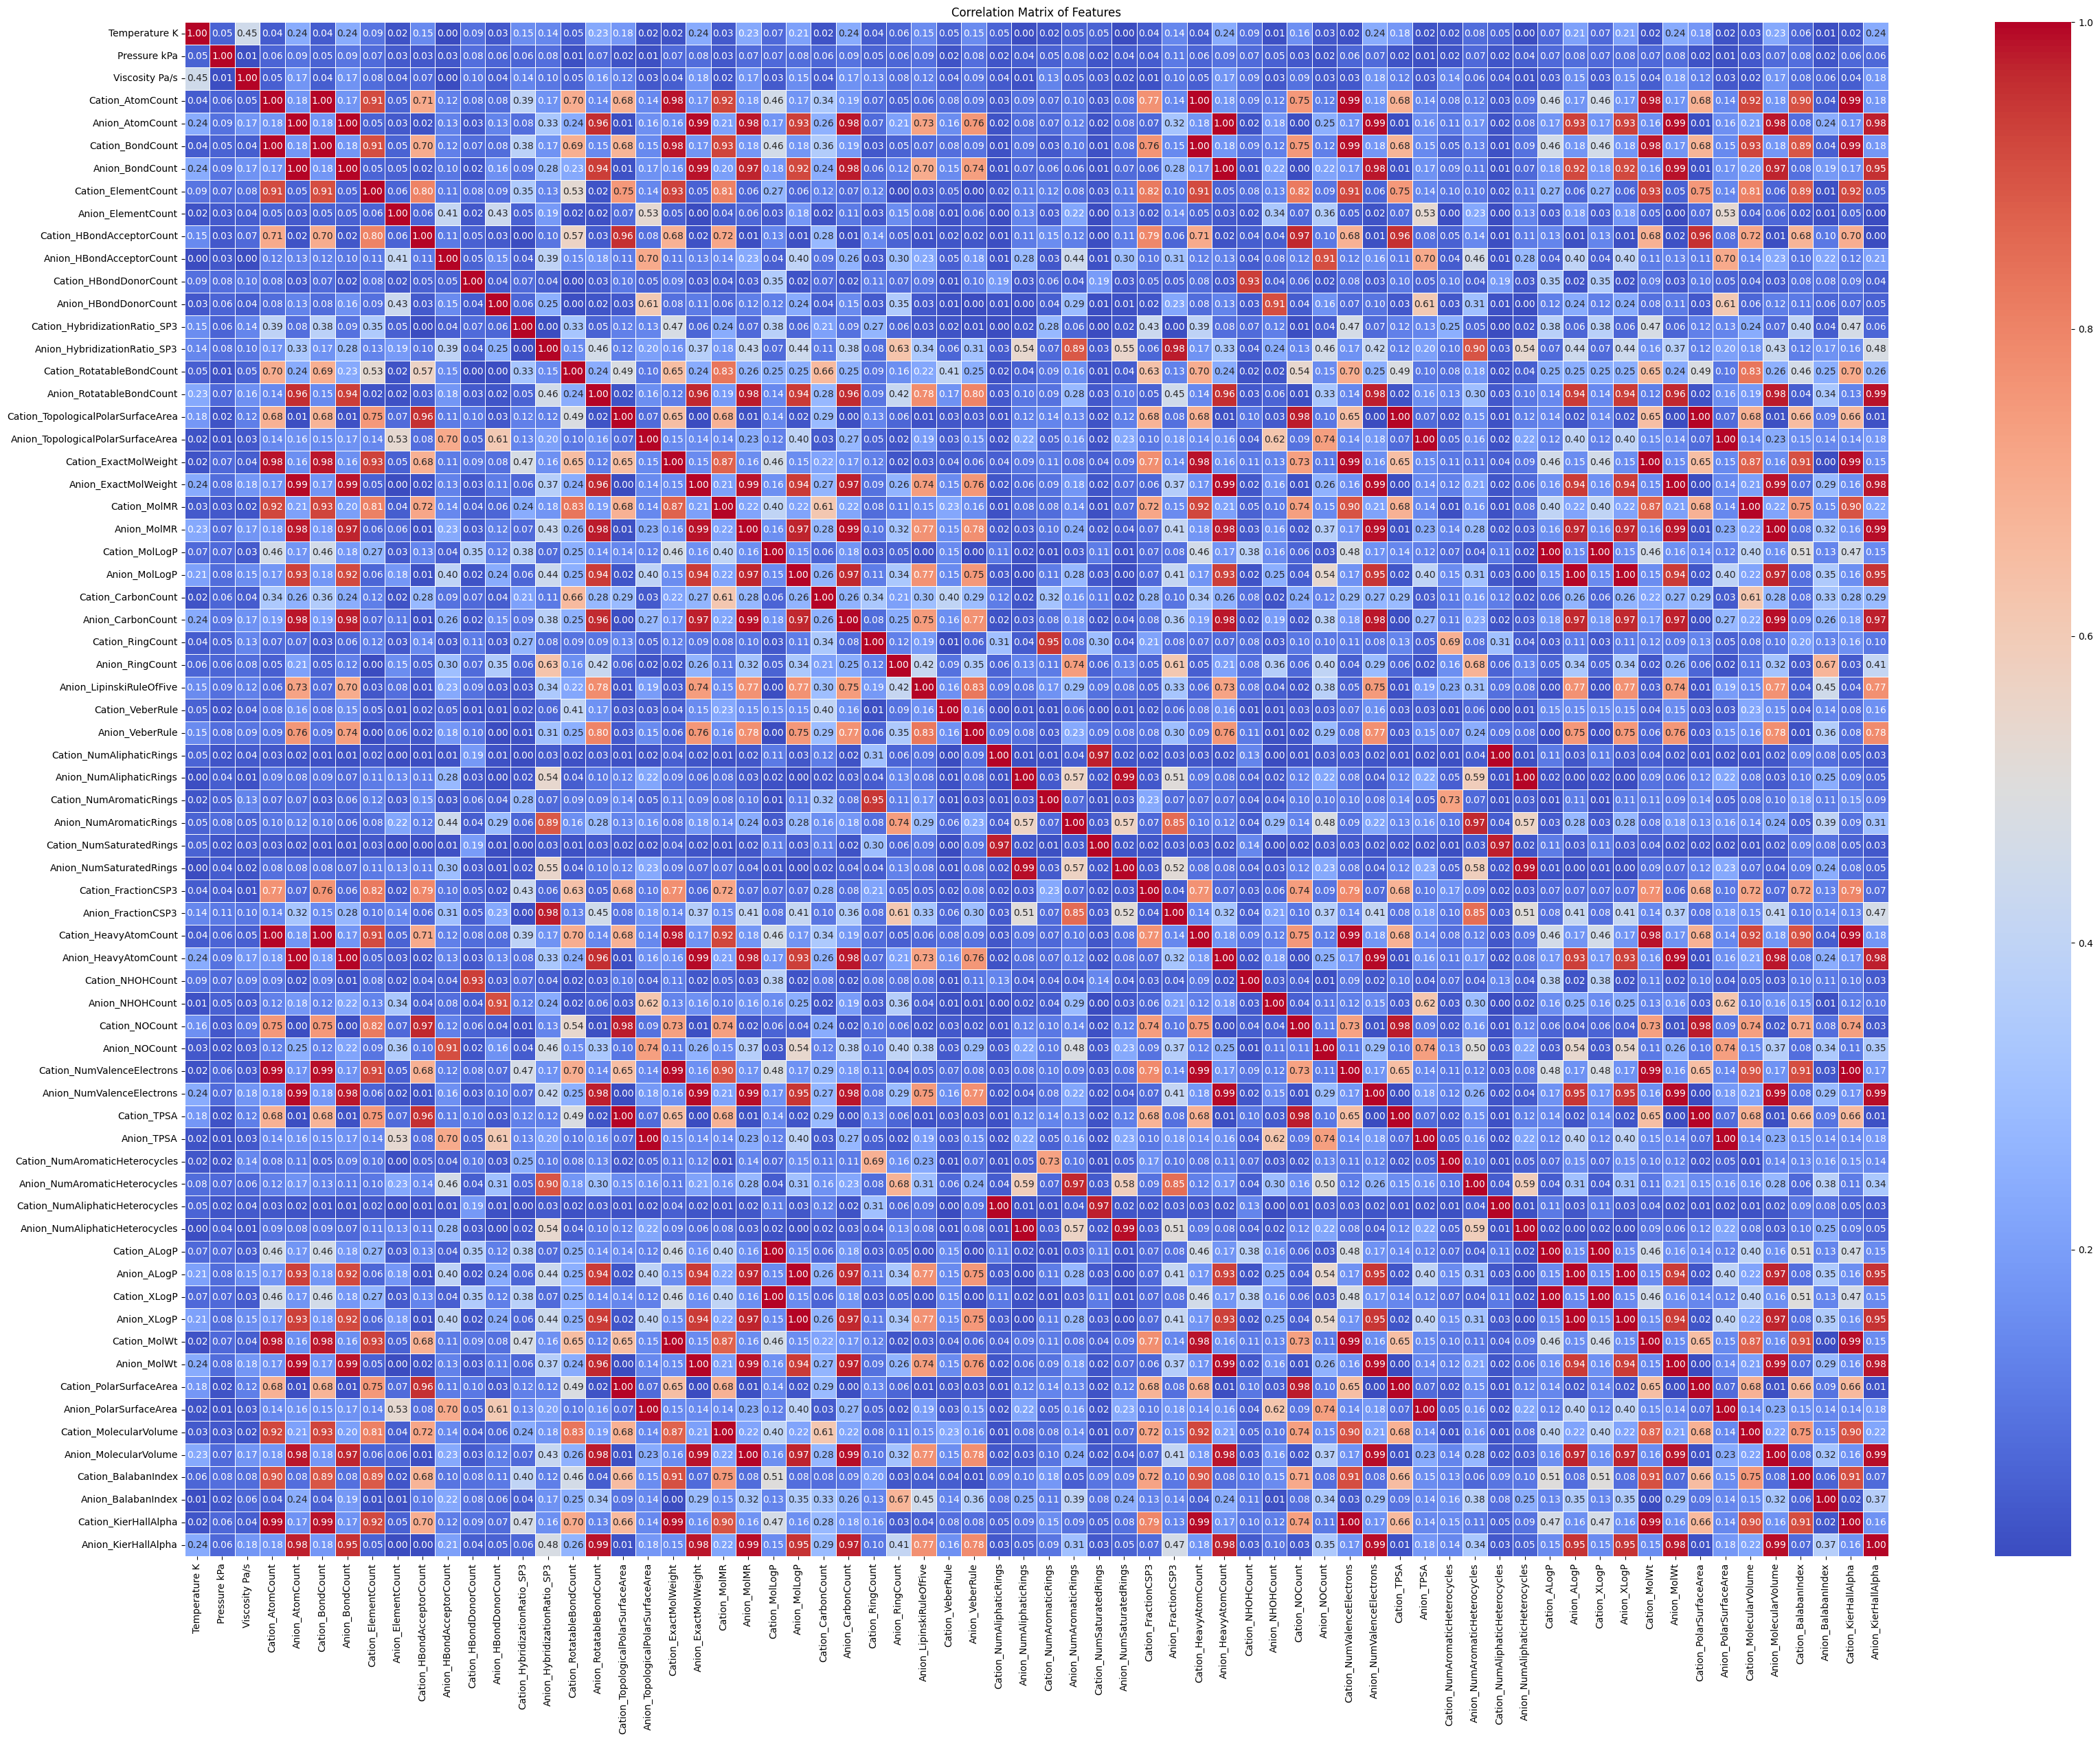

In [30]:


correlation_matrix = df_cleaned.corr().abs()

plt.figure(figsize=(40, 29))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()




**Creation of Training, Validation, and Test Datasets**
1. Training Dataset: Used to train the machine learning model.
2. Validation Dataset: Used to tune the model's hyperparameters and evaluate its performance during training.
3. Test Dataset: Used to assess the final model's performance on unseen data.


Given the size of approximately 20.000 data points, a split of 80% for training, 10% for validation, and 10% for testing is sufficient to ensure the model has enough data to learn effectively, validate its performance, and test its generalizability.

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import xgboost as xgb

X = df_cleaned.drop(columns=['Viscosity Pa/s'])
y_viscosity = np.log(df_cleaned['Viscosity Pa/s'])


X_train_v, X_temp_v, y_train_v, y_temp_v = train_test_split(X, y_viscosity, test_size=0.2, random_state=42)

X_val_v, X_test_v, y_val_v, y_test_v = train_test_split(X_temp_v, y_temp_v, test_size=0.5, random_state=42)




In [32]:
print(X_train_v.shape)

(8106, 67)


In [33]:
X_train_v.head()

Temperature K  Pressure kPa  Cation_AtomCount  Anion_AtomCount  \
9281         313.150       101.325                 5               10   
6812         323.150       101.325                 5                9   
3850         303.150       101.325                 4                5   
8356         298.204       101.325                 7                8   
17171        353.150       101.325                15               15   

       Cation_BondCount  Anion_BondCount  Cation_ElementCount  \
9281                  4               10                    2   
6812                  4                9                    2   
3850                  3                4                    2   
8356                  6                8                    3   
17171                14               15                    5   

       Anion_ElementCount  Cation_HBondAcceptorCount  \
9281                    2                          2   
6812                    2                          0   
3850                    3                          2   
8356                    2                          4   
17171                   2                          4   

       Anion_HBondAcceptorCount  ...  Cation_MolWt  Anion_MolWt  \
9281                          1  ...        66.043      139.222   
6812                          0  ...        86.804      122.191   
3850                          1  ...        59.044       76.119   
8356                          1  ...       125.125      111.168   
17171                         0  ...       280.147      206.353   

       Cation_PolarSurfaceArea  Anion_PolarSurfaceArea  \
9281                     61.68                    8.81   
6812                      0.00                    3.88   
3850                     40.13                   36.84   
8356                     66.43                    8.81   
17171                    82.38                    3.88   

       Cation_MolecularVolume  Anion_MolecularVolume  Cation_BalabanIndex  \
9281                  14.5850                40.5160             2.857272   
6812                  10.1860                36.9280             3.023716   
3850                  10.6810                19.8022             2.803039   
8356                  21.3232                31.2820             3.602197   
17171                 33.3086                64.7740             5.284513   

       Anion_BalabanIndex  Cation_KierHallAlpha  Anion_KierHallAlpha  
9281             2.422978              3.780000             7.318578  
6812             2.614900              4.784935             6.272699  
3850             2.190610              3.470000             4.920000  
8356             2.837541              6.870000             5.348696  
17171            2.299514             14.440000            12.220671  

[5 rows x 67 columns]

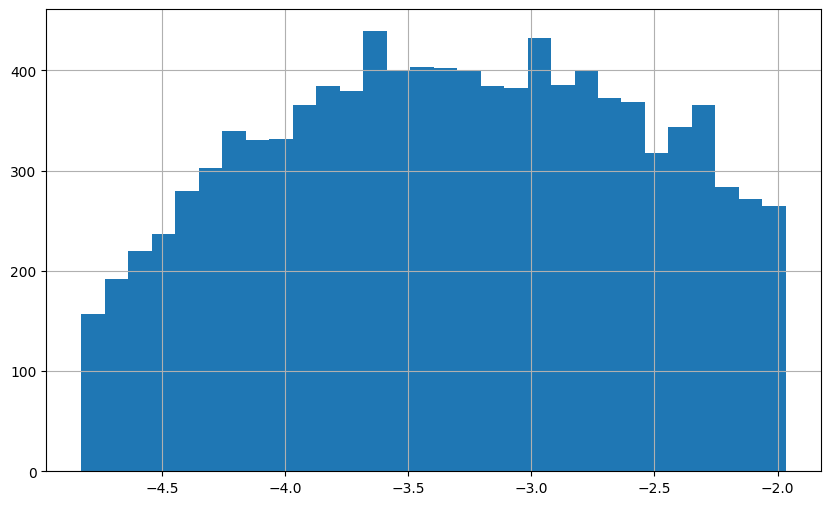

In [34]:
y_viscosity.hist(figsize=(10,6), bins=30)
plt.show()

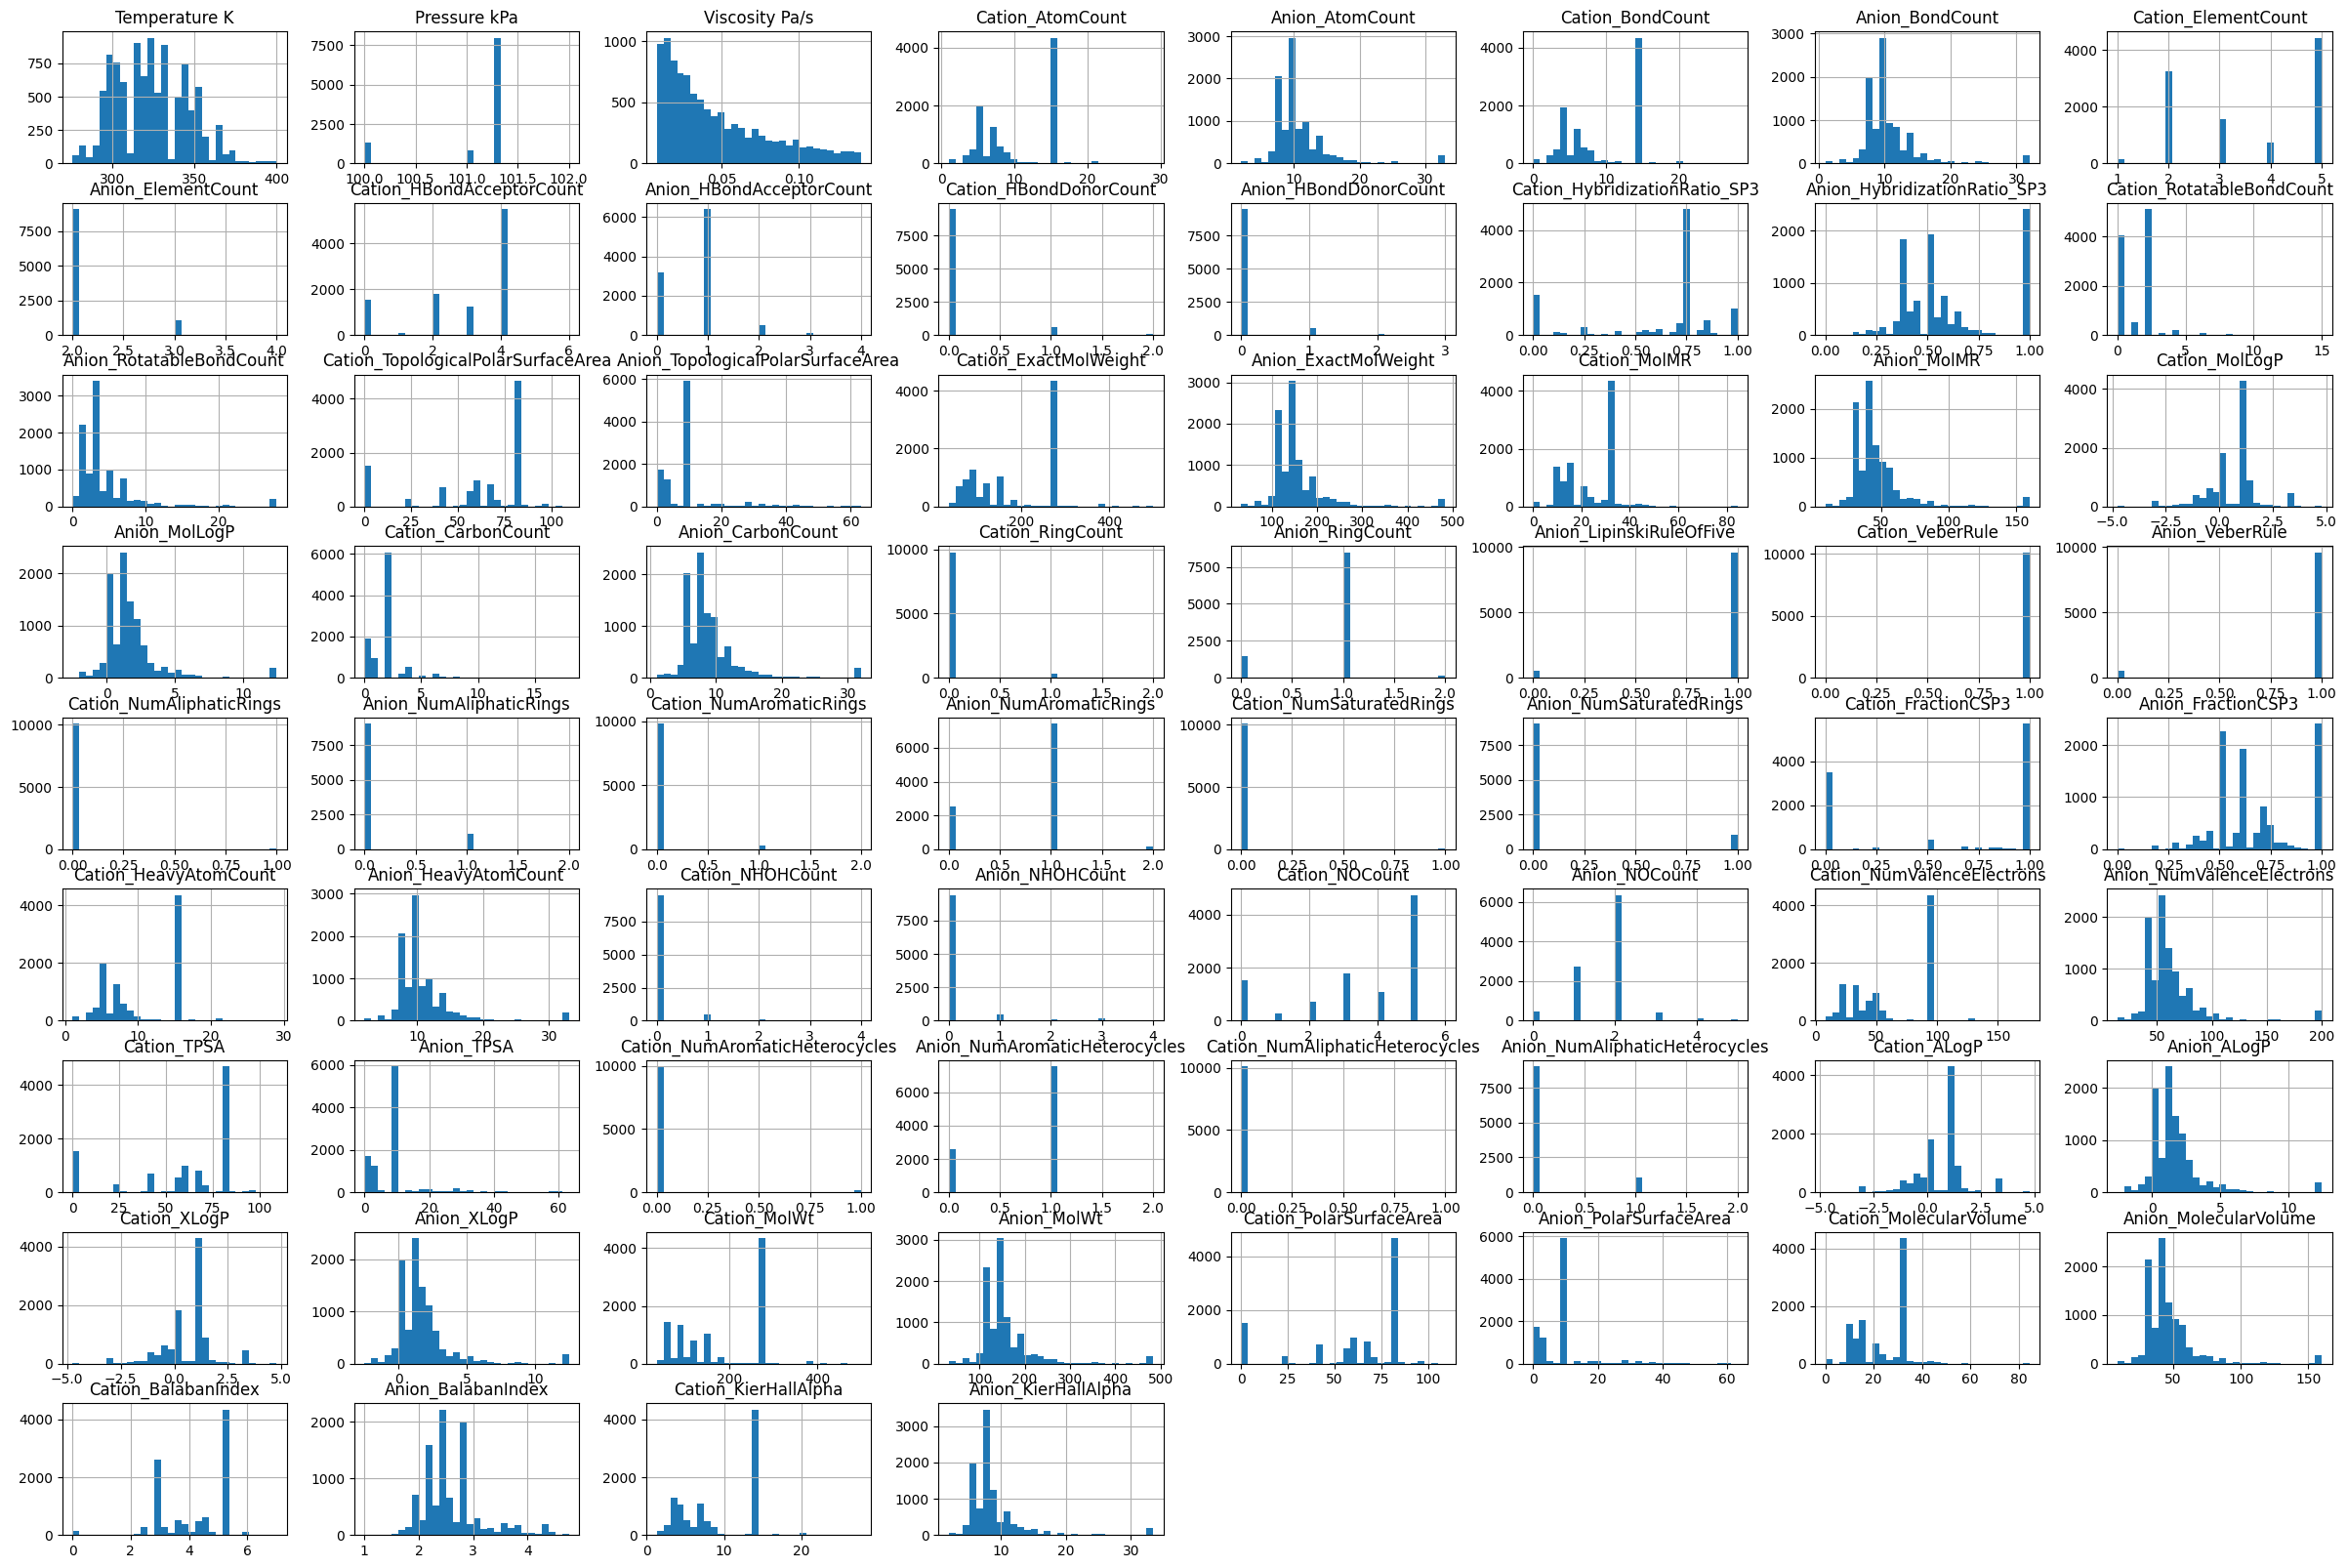

In [35]:
df_cleaned.hist(figsize=(30, 20), bins=30)
plt.show()

We observed that the viscosity data was skewed, so we trained the model on the logarithm of viscosity to normalize the distribution of the data.

# III. Model : XGBOOST


### Hyperparameter Tuning of XGBoost Model

We are optimizing the hyperparameters of an XGBoost regression model to improve its performance. This involves:

1. **Defining a range of values** for key hyperparameters.
2. **Training the model** multiple times with different combinations of these values.
3. **Selecting the best combination** that yields the highest performance based on cross-validation.

This process ensures we find the most effective configuration for our model.


In [36]:
'''
param_grid = {
    'n_estimators': [ 300],
    'max_depth': [5],
    'learning_rate': [0.1, 0.95,1.05],
    'subsample': [0.9],
    'colsample_bytree': [0.7]
}

model_v = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model_v, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2)

grid_search.fit(X_train_v, y_train_v)
best_model_v = grid_search.best_estimator_

'''
best_params = {
    'colsample_bytree': 0.7,
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 300,
    'subsample': 0.9
}



best_model_v = xgb.XGBRegressor(**best_params)


In [37]:


best_model_v.fit(X_train_v, y_train_v, eval_set=[(X_val_v, y_val_v)], early_stopping_rounds=10, verbose=True)
print(f"-----------------------")

val_preds_v_log = best_model_v.predict(X_val_v)
val_preds_v = np.exp(val_preds_v_log)  
val_mse_v = mean_squared_error(np.exp(y_val_v), val_preds_v)  
val_rmse_v = math.sqrt(val_mse_v)
print(f"Validation Mean Squared Error for Viscosity: {val_mse_v}")
print(f"Validation Root Mean Squared Error for Viscosity: {val_rmse_v}")

# Test
test_preds_v_log = best_model_v.predict(X_test_v)
test_preds_v = np.exp(test_preds_v_log) 
test_mse_v = mean_squared_error(np.exp(y_test_v), test_preds_v)  
test_rmse_v = math.sqrt(test_mse_v)
print(f"Test Mean Squared Error for Viscosity: {test_mse_v}")
print(f"Test Root Mean Squared Error for Viscosity: {test_rmse_v}")
print("------------------------------------------")
print(f"Test Root Mean Squared Error for Viscosity in mPa.s: {test_rmse_v*1000}")

[0]	validation_0-rmse:0.70178
[1]	validation_0-rmse:0.68935
[2]	validation_0-rmse:0.65144
[3]	validation_0-rmse:0.61757
[4]	validation_0-rmse:0.58781
[5]	validation_0-rmse:0.56336
[6]	validation_0-rmse:0.54234
[7]	validation_0-rmse:0.51984
[8]	validation_0-rmse:0.50096
[9]	validation_0-rmse:0.49334
[10]	validation_0-rmse:0.47650
[11]	validation_0-rmse:0.46102
[12]	validation_0-rmse:0.45282
[13]	validation_0-rmse:0.43912
[14]	validation_0-rmse:0.43181
[15]	validation_0-rmse:0.42015
[16]	validation_0-rmse:0.41348
[17]	validation_0-rmse:0.40351
[18]	validation_0-rmse:0.39411
[19]	validation_0-rmse:0.38451
[20]	validation_0-rmse:0.37639
[21]	validation_0-rmse:0.36915
[22]	validation_0-rmse:0.36192
[23]	validation_0-rmse:0.35489
[24]	validation_0-rmse:0.34965
[25]	validation_0-rmse:0.34485
[26]	validation_0-rmse:0.33976
[27]	validation_0-rmse:0.33574
[28]	validation_0-rmse:0.33152
[29]	validation_0-rmse:0.32747
[30]	validation_0-rmse:0.32444
[31]	validation_0-rmse:0.31992
[32]	validation_0-

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-rmse:0.30217
[37]	validation_0-rmse:0.30003
[38]	validation_0-rmse:0.29644
[39]	validation_0-rmse:0.29343
[40]	validation_0-rmse:0.29085
[41]	validation_0-rmse:0.28776
[42]	validation_0-rmse:0.28522
[43]	validation_0-rmse:0.28375
[44]	validation_0-rmse:0.27995
[45]	validation_0-rmse:0.27801
[46]	validation_0-rmse:0.27565
[47]	validation_0-rmse:0.27164
[48]	validation_0-rmse:0.26995
[49]	validation_0-rmse:0.26700
[50]	validation_0-rmse:0.26368
[51]	validation_0-rmse:0.26256
[52]	validation_0-rmse:0.26079
[53]	validation_0-rmse:0.25964
[54]	validation_0-rmse:0.25744
[55]	validation_0-rmse:0.25523
[56]	validation_0-rmse:0.25351
[57]	validation_0-rmse:0.25154
[58]	validation_0-rmse:0.25056
[59]	validation_0-rmse:0.24934
[60]	validation_0-rmse:0.24846
[61]	validation_0-rmse:0.24701
[62]	validation_0-rmse:0.24583
[63]	validation_0-rmse:0.24356
[64]	validation_0-rmse:0.24157
[65]	validation_0-rmse:0.24039
[66]	validation_0-rmse:0.23966
[67]	validation_0-rmse:0.23838
[68]	val

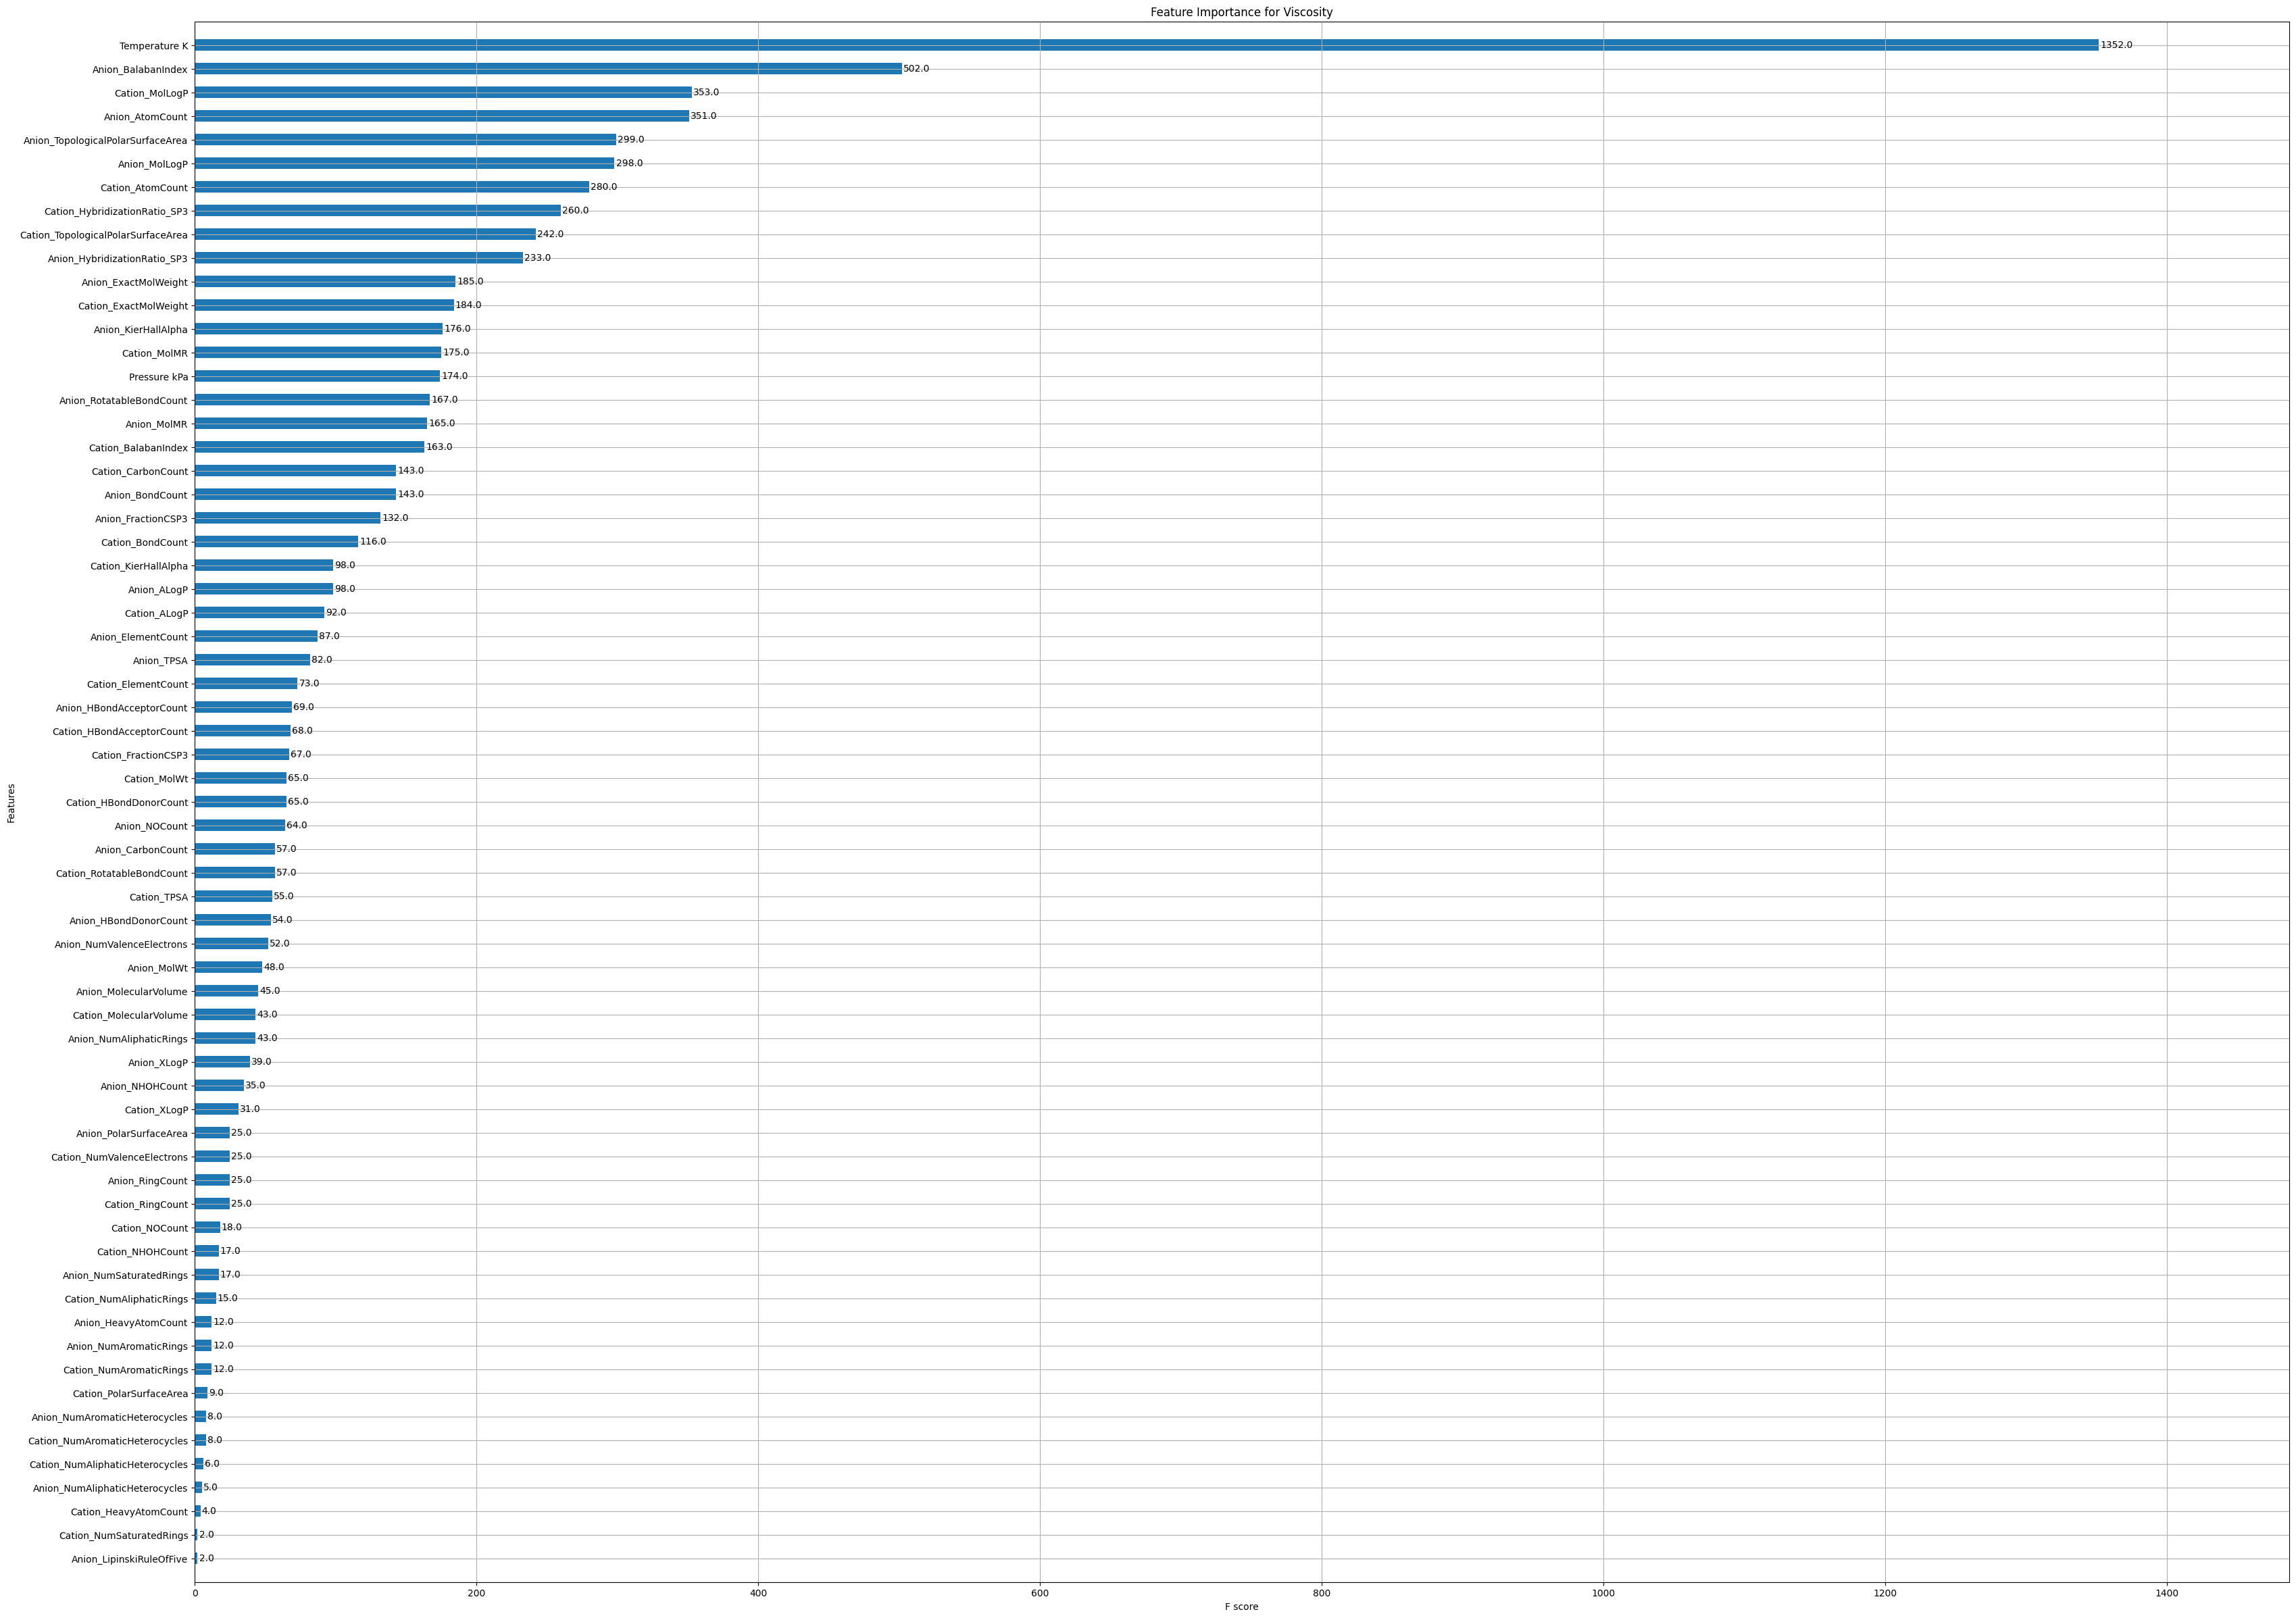

In [38]:

ax = xgb.plot_importance(best_model_v, height=0.5, importance_type='weight')
fig = plt.gcf()
fig.set_size_inches(40, 30) 
plt.title("Feature Importance for Viscosity")
plt.show()


### Comparison of XGBoost Results with Baskin et al. (2022)

| Metric                                   | XGBoost  |
|------------------------------------------|----------|
| Validation Mean Squared Error (MSE)      | 0.0188   |
| Validation Root Mean Squared Error (RMSE)| 0.1373   |
| Test Mean Squared Error (MSE)            | 0.0183   |
| Test Root Mean Squared Error (RMSE)      | 0.1351   |

### Summary

The results of our fine-tuned XGBoost model for predicting the viscosity of ionic liquids show relatively high predictive accuracy. In comparison, Baskin et al. (2022) reported that nonlinear machine learning methods, particularly neural networks, generally perform better than traditional methods for predicting the properties of ionic liquids. The study highlighted that transformer-based neural networks (TransCNN and TransCNF) showed superior performance due to their advanced capabilities in processing SMILES text strings. While our XGBoost model demonstrates good performance, exploring transformer-based models as recommended by Baskin et al. could further enhance predictive accuracy.


Test on a random test value :

In [39]:
import numpy as np
import random


for i in range(10):
    index = random.randint(0, len(X_test_v) - 1)
    single_instance = X_test_v.iloc[index].values.reshape(1, -1)
    predicted_log_viscosity = best_model_v.predict(single_instance)

    predicted_viscosity = np.exp(predicted_log_viscosity)

    accurate_log_viscosity = y_test_v.iloc[index]
    accurate_viscosity = np.exp(accurate_log_viscosity)

    print(f"Predicted Viscosity for index {index}: {predicted_viscosity[0]*1000} mPa.s")
    print(f"Accurate Viscosity for index {index}: {accurate_viscosity*1000} mPa.s")
    print()  
    
    



Predicted Viscosity for index 34: 41.22793674468994 mPa.s
Accurate Viscosity for index 34: 52.29999999999999 mPa.s

Predicted Viscosity for index 289: 9.365285746753216 mPa.s
Accurate Viscosity for index 289: 9.010000000000003 mPa.s

Predicted Viscosity for index 277: 17.12299883365631 mPa.s
Accurate Viscosity for index 277: 17.10000000000001 mPa.s

Predicted Viscosity for index 768: 16.623830422759056 mPa.s
Accurate Viscosity for index 768: 15.84 mPa.s

Predicted Viscosity for index 856: 22.49658666551113 mPa.s
Accurate Viscosity for index 856: 26.500000000000007 mPa.s

Predicted Viscosity for index 918: 67.05734878778458 mPa.s
Accurate Viscosity for index 918: 73.0 mPa.s

Predicted Viscosity for index 933: 68.25678050518036 mPa.s
Accurate Viscosity for index 933: 110.00000000000001 mPa.s

Predicted Viscosity for index 482: 79.8022598028183 mPa.s
Accurate Viscosity for index 482: 90.50000000000001 mPa.s

Predicted Viscosity for index 818: 28.405901044607162 mPa.s
Accurate Viscosity fo

In [40]:
print(f"The 588th element in X_test_v: {X_test_v.iloc[108]}")

The 588th element in X_test_v: Temperature K            358.150000
Pressure kPa             101.325000
Cation_AtomCount          15.000000
Anion_AtomCount           10.000000
Cation_BondCount          14.000000
                            ...    
Anion_MolecularVolume     41.895400
Cation_BalabanIndex        5.284513
Anion_BalabanIndex         2.218745
Cation_KierHallAlpha      14.440000
Anion_KierHallAlpha        8.020806
Name: 4640, Length: 67, dtype: float64


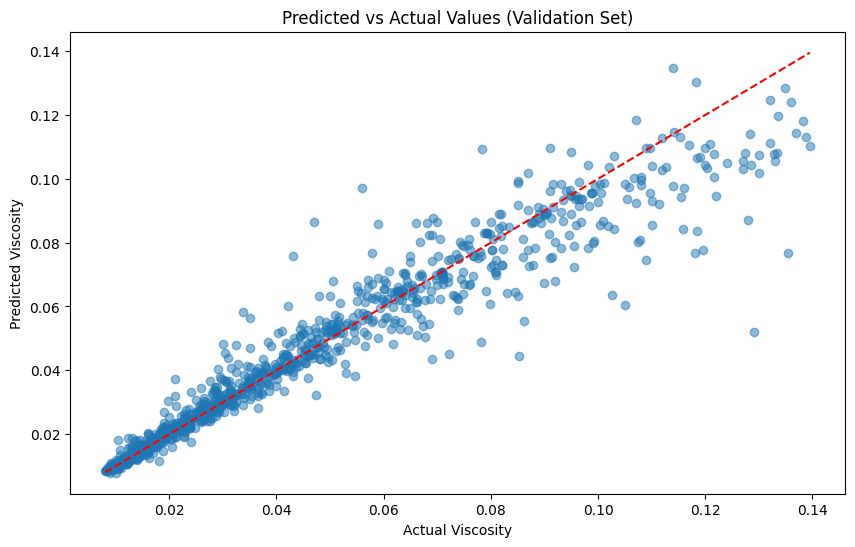

In [41]:

plt.figure(figsize=(10, 6))
plt.scatter(np.exp(y_val_v), val_preds_v, alpha=0.5)
plt.plot([min(np.exp(y_val_v)), max(np.exp(y_val_v))], [min(np.exp(y_val_v)), max(np.exp(y_val_v))], color='red', linestyle='--')
plt.title('Predicted vs Actual Values (Validation Set)')
plt.xlabel('Actual Viscosity')
plt.ylabel('Predicted Viscosity')
plt.show()


In [42]:
val_residuals = y_val_v - val_preds_v

threshold = 1.5 * np.std(val_residuals) 
problematic_indices = np.where(np.abs(val_residuals) > threshold)[0]

problematic_observations = X_val_v.iloc[problematic_indices]
problematic_predictions = val_preds_v[problematic_indices]
problematic_actuals = np.exp(y_val_v.iloc[problematic_indices])

problematic_data = problematic_observations.copy()
problematic_data['Predicted'] = problematic_predictions
problematic_data['Actual'] = problematic_actuals
problematic_data['Residual'] = problematic_data['Actual'] - problematic_data['Predicted']


In [43]:


problematic_means = problematic_observations.mean()

normal_means = df_cleaned.mean()

problematic_viscosity_mean = np.exp(y_val_v.iloc[problematic_indices]).mean()*1000

normal_viscosity_mean = np.exp(y_val_v).mean()*1000

means_df = pd.DataFrame({
    'Feature': df_cleaned.columns,
    'Problematic Mean': problematic_means,
    'Normal Mean': normal_means
}).set_index('Feature')

means_df.loc['Viscosity'] = [problematic_viscosity_mean, normal_viscosity_mean]

means_df


Problematic Mean  Normal Mean
Feature                                            
Temperature K                 1.698171     1.716758
Pressure kPa                 11.016782    11.045594
Viscosity Pa/s                2.608035     2.604176
Cation_AtomCount             10.893386    10.917004
Anion_AtomCount               9.249753     9.255798
...                                ...          ...
Cation_BalabanIndex           0.606747     0.611855
Anion_BalabanIndex          101.142177   101.126495
Cation_KierHallAlpha        324.269072   323.790372
Anion_KierHallAlpha                NaN     0.046594
Viscosity                    45.376443    45.376443

[69 rows x 2 columns]

In [44]:
import pandas as pd
import numpy as np
import requests
from rdkit import Chem
from rdkit.Chem import Descriptors


def iupac_to_smiles(iupac_name):
    url = f'https://opsin.ch.cam.ac.uk/opsin/{iupac_name}.json'
    try:
        response = requests.get(url)
        response.raise_for_status() 
        return response.json().get('smiles', "")
    except requests.RequestException as e:
        print(f"Erreur lors de la requête à l'API: {e}")
        return ""


def prepare_data(iupac_name, temperature, pressure, viscosity):
    smiles = iupac_to_smiles(iupac_name)
    if not smiles:
        print("Conversion to SMILES failed.")
        return pd.DataFrame()


    data = {
        "Components": [iupac_name],
        "Temperature K": [temperature],
        "Pressure kPa": [pressure],
        "Viscosity Pa/s": [viscosity * 0.001],  
        "DeltaViscosity": [0],  
        "SMILES": [smiles],
    }

    df = pd.DataFrame(data)
    df_descriptors = df['SMILES'].apply(process_ionic_liquid)
    valid_mask = df_descriptors.notnull()
    df = df[valid_mask].reset_index(drop=True)
    df_descriptors = pd.DataFrame(list(df_descriptors.dropna()))

    df = pd.concat([df, df_descriptors], axis=1)
    
    df = df.drop(columns=["SMILES", "DeltaViscosity", "Components"])
    df.drop('Cation_LipinskiRuleOfFive',inplace = True, axis = 1)
    
    return df

# Test with given
iupac_name = "1-Decyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide"
temperature = 308.15
pressure = 101.325
viscosity = 63.29

df_prepared = prepare_data(iupac_name, temperature, pressure, viscosity)






In [45]:
'''
test_path = '/kaggle/input/tedsqdzd/RES2.csv'
# Read the CSV file
df_test = pd.read_csv(test_path)'''


X_test = df_prepared.drop(columns=['Viscosity Pa/s'])
y_test_viscosity = np.log(df_prepared['Viscosity Pa/s'])


In [46]:
print(X_test.columns)

Index(['Temperature K', 'Pressure kPa', 'Cation_AtomCount', 'Anion_AtomCount',
       'Cation_BondCount', 'Anion_BondCount', 'Cation_ElementCount',
       'Anion_ElementCount', 'Cation_HBondAcceptorCount',
       'Anion_HBondAcceptorCount', 'Cation_HBondDonorCount',
       'Anion_HBondDonorCount', 'Cation_HybridizationRatio_SP3',
       'Anion_HybridizationRatio_SP3', 'Cation_RotatableBondCount',
       'Anion_RotatableBondCount', 'Cation_TopologicalPolarSurfaceArea',
       'Anion_TopologicalPolarSurfaceArea', 'Cation_ExactMolWeight',
       'Anion_ExactMolWeight', 'Cation_MolMR', 'Anion_MolMR', 'Cation_MolLogP',
       'Anion_MolLogP', 'Cation_CarbonCount', 'Anion_CarbonCount',
       'Cation_RingCount', 'Anion_RingCount', 'Anion_LipinskiRuleOfFive',
       'Cation_VeberRule', 'Anion_VeberRule', 'Cation_NumAliphaticRings',
       'Anion_NumAliphaticRings', 'Cation_NumAromaticRings',
       'Anion_NumAromaticRings', 'Cation_NumSaturatedRings',
       'Anion_NumSaturatedRings', 'Cation

In [47]:
index = random.randint(0, len(X_test) - 1)
single_instance = X_test.iloc[index].values.reshape(1, -1)
predicted_log_viscosity = best_model_v.predict(single_instance)

predicted_viscosity = np.exp(predicted_log_viscosity)

accurate_log_viscosity = y_test_viscosity.iloc[index]
accurate_viscosity = np.exp(accurate_log_viscosity)

print(f"Predicted Viscosity for index {index}: {predicted_viscosity[0]*1000} mPa.s")
print(f"Accurate Viscosity for index {index}: {accurate_viscosity*1000} mPa.s")

Predicted Viscosity for index 0: 77.30094343423843 mPa.s
Accurate Viscosity for index 0: 63.29000000000001 mPa.s


In [48]:
# Function to calculate the accuracy
def calculate_accuracy(predicted, actual):
    return abs(predicted - actual) / actual * 100

# List of examples
examples = [
    ("1-Ethyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 293.15, 101.325, 36.46),
    ("1-Butyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 293.15, 101.325, 60.65),
    ("1-Octyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 293.15, 101.325, 116.9),
    ("1-Decyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 293.15, 101.325, 131.6),
    ("1-Ethyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 298.15, 101.325, 30.43),
    ("1-Butyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 298.15, 101.325, 48.68),
    ("1-Octyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 298.15, 101.325, 90.70),
    ("1-Decyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 298.15, 101.325, 100.9),
    ("1-Ethyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 303.15, 101.325, 25.73),
    ("1-Butyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 303.15, 101.325, 39.76),
    ("1-Octyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 303.15, 101.325, 71.81),
    ("1-Decyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 303.15, 101.325, 79.51),
    ("1-Ethyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 308.15, 101.325, 22.03),
    ("1-Butyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 308.15, 101.325, 32.96),
    ("1-Octyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 308.15, 101.325, 57.68),
    ("1-Decyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 308.15, 101.325, 63.29),
    ("1-Ethyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 313.15, 101.325, 19.05),
    ("1-Butyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 313.15, 101.325, 27.71),
    ("1-Octyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 313.15, 101.325, 47.82),
    ("1-Decyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 313.15, 101.325, 51.14),
    ("1-Ethyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 318.15, 101.325, 16.65),
    ("1-Butyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 318.15, 101.325, 23.57),
    ("1-Octyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 318.15, 101.325, 40.36),
    ("1-Decyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide", 318.15, 101.325, 41.96),
]


accuracies = []
comparison_table = []

for iupac_name, temperature, pressure, viscosity in examples:
    df_prepared = prepare_data(iupac_name, temperature, pressure, viscosity)
    if df_prepared.empty:
        continue
    X_test = df_prepared.drop(columns=['Viscosity Pa/s'])
    y_test_viscosity = np.log(df_prepared['Viscosity Pa/s'])
    index = random.randint(0, len(X_test) - 1)
    single_instance = X_test.iloc[index].values.reshape(1, -1)
    predicted_log_viscosity = best_model_v.predict(single_instance)

    predicted_viscosity = np.exp(predicted_log_viscosity)

    accurate_log_viscosity = y_test_viscosity.iloc[index]
    accurate_viscosity = np.exp(accurate_log_viscosity)

    accuracy = calculate_accuracy(predicted_viscosity[0]*1000, accurate_viscosity*1000)
    accuracies.append(accuracy)

    comparison_table.append({
        'Compound': iupac_name,
        'Predicted Viscosity (mPa.s)': predicted_viscosity[0] * 1000,
        'Actual Viscosity (mPa.s)': accurate_viscosity * 1000,
        'Accuracy (%)': accuracy
    })

average_accuracy = np.mean(accuracies)

comparison_df = pd.DataFrame(comparison_table)

print(comparison_df)

print(f"Average accuracy (%): {average_accuracy}")



                                             Compound  \
0   1-Ethyl-3-methylimidazolium bis(trifluoromethy...   
1   1-Butyl-3-methylimidazolium bis(trifluoromethy...   
2   1-Octyl-3-methylimidazolium bis(trifluoromethy...   
3   1-Decyl-3-methylimidazolium bis(trifluoromethy...   
4   1-Ethyl-3-methylimidazolium bis(trifluoromethy...   
5   1-Butyl-3-methylimidazolium bis(trifluoromethy...   
6   1-Octyl-3-methylimidazolium bis(trifluoromethy...   
7   1-Decyl-3-methylimidazolium bis(trifluoromethy...   
8   1-Ethyl-3-methylimidazolium bis(trifluoromethy...   
9   1-Butyl-3-methylimidazolium bis(trifluoromethy...   
10  1-Octyl-3-methylimidazolium bis(trifluoromethy...   
11  1-Decyl-3-methylimidazolium bis(trifluoromethy...   
12  1-Ethyl-3-methylimidazolium bis(trifluoromethy...   
13  1-Butyl-3-methylimidazolium bis(trifluoromethy...   
14  1-Octyl-3-methylimidazolium bis(trifluoromethy...   
15  1-Decyl-3-methylimidazolium bis(trifluoromethy...   
16  1-Ethyl-3-methylimidazolium

# 